Observation space: Box(0, 255, (96, 96, 3), uint8)
Action space: Discrete(5)
(96, 96, 3)


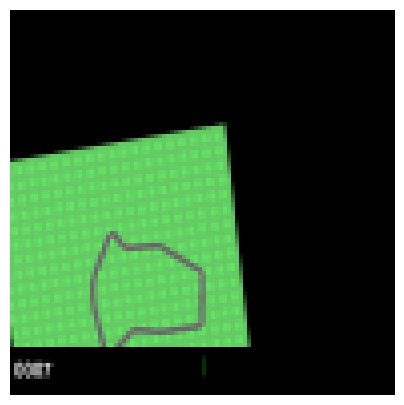

The shape of an observation: (4, 84, 84)


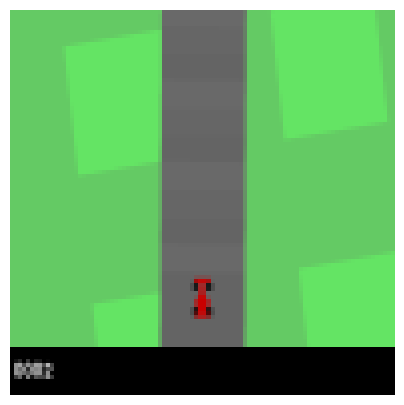

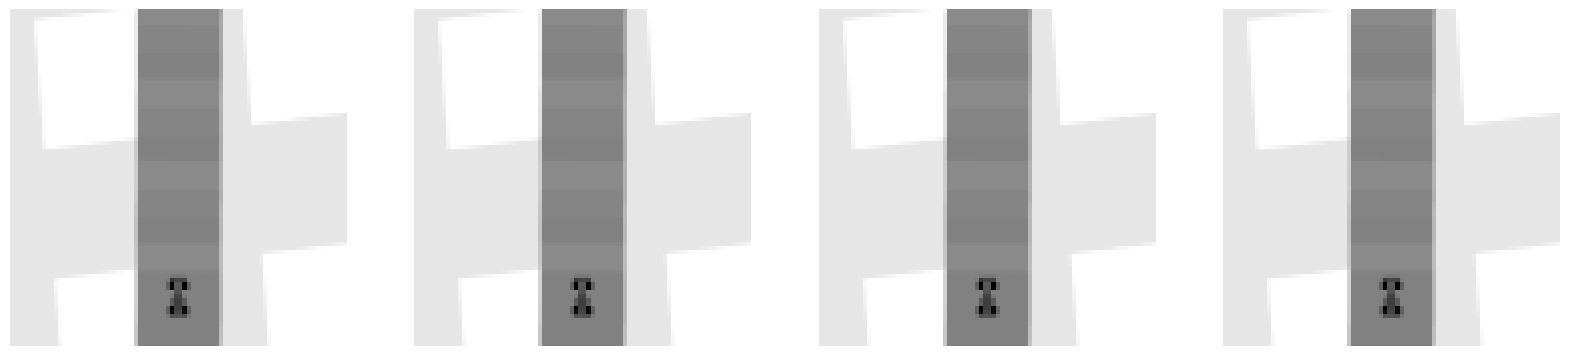

Steps: 100 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 200 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 300 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 400 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 500 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 600 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 700 | Returns: -94.99999999999736
Model saved to dqn_carracing.pth
Steps: 800 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 900 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 1000 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Steps: 1100 | Returns: -94.99999999999736
Model saved to dqn_carracing.pth


KeyboardInterrupt: 

In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import random
import string
import os
import matplotlib.animation as animation
from IPython.display import HTML

# Set up the environment
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

s, info = env.reset()
print(s.shape)

plt.figure(figsize=(5, 5))
plt.imshow(s)
plt.axis('off')
plt.show()

# Animation setup
frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0th action is the no_op action
    frames.append(s)

fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])

def animate(i):
    im.set_array(frames[i])
    return im,

anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

# Preprocess the frames
def preprocess(img):
    img = img[:84, 6:90]  # Car Racing v2 specific cropping
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

# Image environment wrapper
class ImageEnv(gym.Wrapper):
    def __init__(self, env, skip_frames=4, stack_frames=4, initial_no_op=50, **kwargs):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    def reset(self):
        s, info = self.env.reset()
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)
        s = preprocess(s)
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))
        return self.stacked_state, info

    def step(self, action):
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break
        s = preprocess(s)
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)
        return self.stacked_state, reward, terminated, truncated, info

env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation:", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Define the DQN components
class CNNActionValue(nn.Module):
    def __init__(self, state_dim, action_dim, activation=F.relu):
        super(CNNActionValue, self).__init__()
        self.conv1 = nn.Conv2d(state_dim, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.in_features = 32 * 9 * 9
        self.fc1 = nn.Linear(self.in_features, 256)
        self.fc2 = nn.Linear(256, action_dim)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = x.view(-1, self.in_features)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, max_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size=32):
        idx = np.random.choice(self.size, batch_size, replace=False)
        return (
            torch.FloatTensor(self.s[idx]),
            torch.FloatTensor(self.a[idx]),
            torch.FloatTensor(self.r[idx]),
            torch.FloatTensor(self.s_prime[idx]),
            torch.FloatTensor(self.terminated[idx]),
        )

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, gamma=0.99, lr=1e-3, batch_size=32):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.q = CNNActionValue(state_dim[0], action_dim).cuda()
        self.q_target = CNNActionValue(state_dim[0], action_dim).cuda()
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.eval()
        self.optimizer = torch.optim.Adam(self.q.parameters(), lr=lr)
        self.criteria = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(state_dim, (1,))
        self.total_steps = 0

    def act(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).cuda()
        with torch.no_grad():
            return self.q(state).argmax(dim=1).item()

    def process(self, transition):
        self.replay_buffer.update(*transition)
        self.total_steps += 1
        if self.total_steps % 100 == 0:
            self.update_q()
        if self.total_steps % 1000 == 0:
            self.q_target.load_state_dict(self.q.state_dict())
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return {'total_steps': self.total_steps} if self.total_steps % 100 == 0 else {}

    def update_q(self):
        if self.replay_buffer.size < self.batch_size:
            return
        s, a, r, s_prime, terminated = self.replay_buffer.sample(self.batch_size)
        q = self.q(s.cuda()).gather(1, a.long().cuda())
        with torch.no_grad():
            q_prime = self.q_target(s_prime.cuda()).max(1, keepdim=True)[0]
            target = r.cuda() + self.gamma * q_prime * (1 - terminated.cuda())
        loss = self.criteria(q, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save_model(self, path):
        torch.save(self.q.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        self.q.load_state_dict(torch.load(path))
        self.q_target.load_state_dict(self.q.state_dict())
        print(f"Model loaded from {path}")

def evaluate(agent, n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    scores = 0
    for _ in range(n_evals):
        s, _ = eval_env.reset()
        terminated = False
        truncated = False
        while not terminated and not truncated:
            a = agent.act(s, training=False)
            s, r, terminated, truncated, info = eval_env.step(a)
            scores += r
    return scores / n_evals

# Initialize the agent
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)

# Training and evaluation
max_steps = 1000  # You can adjust this value based on your needs
save_interval = 100  # Save the model every 1000 steps
save_path = "dqn_carracing.pth"

returns, steps = [], []
for step in range(0, max_steps + 1):
    s, _ = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        a = agent.act(s)
        s_prime, r, terminated, truncated, info = env.step(a)
        terminated = terminated or truncated
        result = agent.process((s, [a], [r], s_prime, [terminated]))
        s = s_prime
        if len(result):
            steps.append(result['total_steps'])
            returns.append(evaluate(agent))
            print(f"Steps: {result['total_steps']} | Returns: {returns[-1]}")
            if result['total_steps'] % save_interval == 0:
                agent.save_model(save_path)

# Save the model at the end of training
agent.save_model(save_path)

# Plotting the returns
plt.figure(figsize=(10, 5))
plt.plot(steps, returns)
plt.xlabel('steps')
plt.ylabel('return')
plt.grid()
plt.show()

def save_video(agent, filename, n_episodes=1):
    frames = []
    for _ in range(n_episodes):
        s, _ = env.reset()
        terminated = False
        truncated = False
        while not terminated and not truncated:
            a = agent.act(s, training=False)
            s, r, terminated, truncated, info = env.step(a)
            frames.append(env.render(mode='rgb_array'))
    height, width, layers = frames[0].shape
    video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    video.release()
    print(f"Video saved as {filename}")

save_video(agent, 'carracing_dqn.mp4', n_episodes=5)


In [ ]:
#########################################

Observation space: Box(0, 255, (96, 96, 3), uint8)
Action space: Discrete(5)
(96, 96, 3)


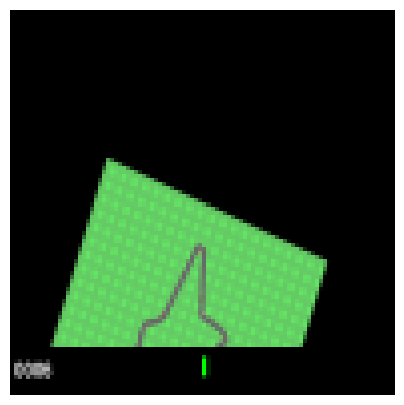

The shape of an observation: (4, 84, 84)


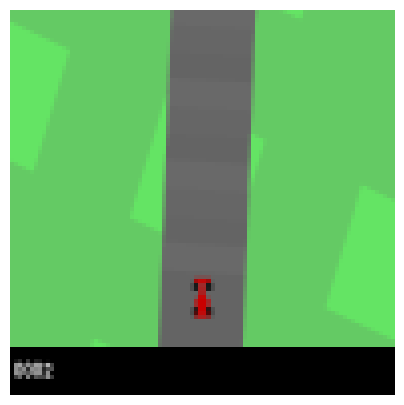

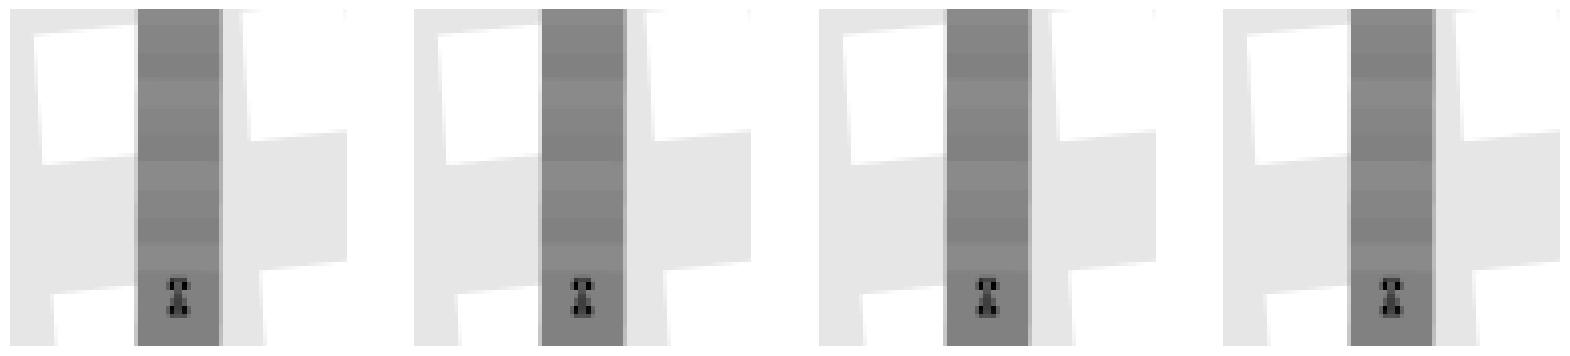

Steps: 100 | Returns: -94.99999999999736
Model saved to dqn_carracing.pth
Steps: 200 | Returns: -94.99999999999737
Model saved to dqn_carracing.pth
Breaking out of the loop
Model saved to dqn_carracing.pth


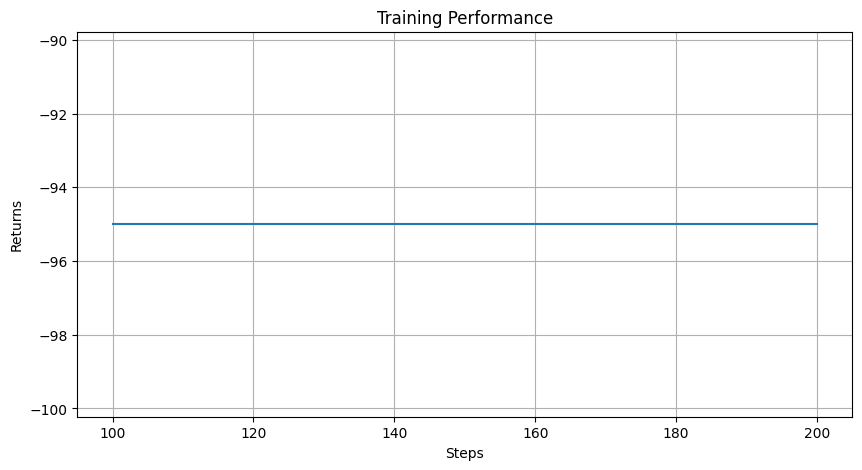

TypeError: render() got an unexpected keyword argument 'mode'

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
import random
import string
import os
import matplotlib.animation as animation
from IPython.display import HTML

# Set up the environment
env = gym.make('CarRacing-v2', continuous=False)
print("Observation space:", env.observation_space)
print("Action space:", env.action_space)

s, info = env.reset()
print(s.shape)

plt.figure(figsize=(5, 5))
plt.imshow(s)
plt.axis('off')
plt.show()

# Animation setup
frames = []
for i in range(50):
    s, r, terminated, truncated, info = env.step(0)  # 0th action is the no_op action
    frames.append(s)

fig = plt.figure(figsize=(5, 5))
plt.axis('off')
im = plt.imshow(frames[0])

def animate(i):
    im.set_array(frames[i])
    return im,

anim = animation.FuncAnimation(fig, animate, frames=len(frames))
HTML(anim.to_jshtml())

# Preprocess the frames
def preprocess(img):
    img = img[:84, 6:90]  # Car Racing v2 specific cropping
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

# Image environment wrapper
class ImageEnv(gym.Wrapper):
    def __init__(self, env, skip_frames=4, stack_frames=4, initial_no_op=50, **kwargs):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    def reset(self):
        s, info = self.env.reset()
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)
        s = preprocess(s)
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))
        return self.stacked_state, info

    def step(self, action):
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break
        s = preprocess(s)
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)
        return self.stacked_state, reward, terminated, truncated, info

env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation:", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Define the DQN components
class CNNActionValue(nn.Module):
    def __init__(self, state_dim, action_dim, activation=F.relu):
        super(CNNActionValue, self).__init__()
        self.conv1 = nn.Conv2d(state_dim, 16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=4, stride=2)
        self.in_features = 32 * 9 * 9
        self.fc1 = nn.Linear(self.in_features, 256)
        self.fc2 = nn.Linear(256, action_dim)
        self.activation = activation

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.activation(self.conv2(x))
        x = x.view(-1, self.in_features)
        x = self.activation(self.fc1(x))
        x = self.fc2(x)
        return x

class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)
        self.ptr, self.size, self.max_size = 0, 0, max_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size=32):
        idx = np.random.choice(self.size, batch_size, replace=False)
        return (
            torch.FloatTensor(self.s[idx]),
            torch.FloatTensor(self.a[idx]),
            torch.FloatTensor(self.r[idx]),
            torch.FloatTensor(self.s_prime[idx]),
            torch.FloatTensor(self.terminated[idx]),
        )

class DQNAgent:
    def __init__(self, state_dim, action_dim, epsilon=1.0, epsilon_min=0.1, epsilon_decay=0.995, gamma=0.99, lr=1e-3, batch_size=32):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.gamma = gamma
        self.batch_size = batch_size
        self.q = CNNActionValue(state_dim[0], action_dim).cuda()
        self.q_target = CNNActionValue(state_dim[0], action_dim).cuda()
        self.q_target.load_state_dict(self.q.state_dict())
        self.q_target.eval()
        self.optimizer = torch.optim.Adam(self.q.parameters(), lr=lr)
        self.criteria = nn.MSELoss()
        self.replay_buffer = ReplayBuffer(state_dim, (1,))
        self.total_steps = 0

    def act(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        state = torch.FloatTensor(state).unsqueeze(0).cuda()
        with torch.no_grad():
            return self.q(state).argmax(dim=1).item()

    def process(self, transition):
        self.replay_buffer.update(*transition)
        self.total_steps += 1
        if self.total_steps % 100 == 0:
            self.update_q()
        if self.total_steps % 1000 == 0:
            self.q_target.load_state_dict(self.q.state_dict())
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return {'total_steps': self.total_steps} if self.total_steps % 100 == 0 else {}

    def update_q(self):
        if self.replay_buffer.size < self.batch_size:
            return
        s, a, r, s_prime, terminated = self.replay_buffer.sample(self.batch_size)
        q = self.q(s.cuda()).gather(1, a.long().cuda())
        with torch.no_grad():
            q_prime = self.q_target(s_prime.cuda()).max(1, keepdim=True)[0]
            target = r.cuda() + self.gamma * q_prime * (1 - terminated.cuda())
        loss = self.criteria(q, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save_model(self, path):
        torch.save(self.q.state_dict(), path)
        print(f"Model saved to {path}")

    def load_model(self, path):
        self.q.load_state_dict(torch.load(path))
        self.q_target.load_state_dict(self.q.state_dict())
        print(f"Model loaded from {path}")

def evaluate(agent, n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    scores = 0
    for _ in range(n_evals):
        s, _ = eval_env.reset()
        terminated = False
        truncated = False
        while not terminated and not truncated:
            a = agent.act(s, training=False)
            s, r, terminated, truncated, info = eval_env.step(a)
            scores += r
    return scores / n_evals

# Initialize the agent
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)

# Training and evaluation
max_steps = 100  # You can adjust this value based on your needs
save_interval = 10  # Save the model every 1000 steps
save_path = "dqn_carracing.pth"

returns, steps = [], []
for step in range(0, max_steps + 1):
    s, _ = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        a = agent.act(s)
        s_prime, r, terminated, truncated, info = env.step(a)
        terminated = terminated or truncated
        result = agent.process((s, [a], [r], s_prime, [terminated]))
        s = s_prime
        if len(result):
            steps.append(result['total_steps'])
            returns.append(evaluate(agent))
            print(f"Steps: {result['total_steps']} | Returns: {returns[-1]}")
            if result['total_steps'] % save_interval == 0:
                agent.save_model(save_path)
        # if agent.total_steps > max_steps:
        #     print("Breaking out of the loop")
        #     break  # Uncommented this line
    if agent.total_steps > max_steps:
        print("Breaking out of the loop")
        break  # Added this line

# Save the model at the end of training
agent.save_model(save_path)

# Plotting the returns
plt.figure(figsize=(10, 5))
plt.plot(steps, returns)
plt.xlabel('Steps')
plt.ylabel('Returns')
plt.title('Training Performance')
plt.grid()
plt.show()

def save_video(agent, filename, n_episodes=1):
    frames = []
    for _ in range(n_episodes):
        s, _ = env.reset()
        terminated = False
        truncated = False
        while not terminated and not truncated:
            a = agent.act(s, training=False)
            s, r, terminated, truncated, info = env.step(a)
            frames.append(env.render(mode='rgb_array'))
    height, width, layers = frames[0].shape
    video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    video.release()
    print(f"Video saved as {filename}")

save_video(agent, 'carracing_dqn.mp4', n_episodes=5)


In [6]:
eval_env = gym.make('CarRacing-v2', continuous = False, render_mode = 'rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores =0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    a = agent.act(s, training = False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

def save_video(agent, filename, n_episodes=1):
    frames = []
    for _ in range(n_episodes):
        s, _ = env.reset()
        terminated = False
        truncated = False
        while not terminated and not truncated:
            a = agent.act(s, training=False)
            s, r, terminated, truncated, info = env.step(a)
            frame = env.render()
            if frame is not None:  # Check if the frame is not None
                frames.append(frame)
    if not frames:
        print("No frames to save. Exiting.")
        return

    height, width, _ = frames[0].shape
    video = cv2.VideoWriter(filename, cv2.VideoWriter_fourcc(*'mp4v'), 30, (width, height))
    for frame in frames:
        video.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))
    video.release()
    print(f"Video saved as {filename}")

save_video(agent, 'carracing_dqn.mp4', n_episodes=5)


No frames to save. Exiting.


In [ ]:
# To load the saved model and use it for evaluation or further training.

In [ ]:
# Initialize the agent
state_dim = (4, 84, 84)
action_dim = env.action_space.n
agent = DQNAgent(state_dim, action_dim)

# Load the saved model
save_path = "dqn_carracing.pth"
agent.load_model(save_path)

# Evaluate the loaded model
print("Evaluating the loaded model...")
average_return = evaluate(agent, n_evals=5)
print(f"Average return: {average_return}")

# Optionally, you can continue training from the loaded model
max_steps = 5000  # Continue training for additional steps
save_interval = 1000  # Save the model every 1000 steps

returns, steps = [], []
for step in range(0, max_steps + 1):
    s, _ = env.reset()
    terminated = False
    truncated = False
    while not terminated and not truncated:
        a = agent.act(s)
        s_prime, r, terminated, truncated, info = env.step(a)
        terminated = terminated or truncated
        result = agent.process((s, [a], [r], s_prime, [terminated]))
        s = s_prime
        if len(result):
            steps.append(result['total_steps'])
            returns.append(evaluate(agent))
            print(f"Steps: {result['total_steps']} | Returns: {returns[-1]}")
            if result['total_steps'] % save_interval == 0:
                agent.save_model(save_path)

# Save the model at the end of additional training
agent.save_model(save_path)

# Plotting the returns after additional training
plt.figure(figsize=(10, 5))
plt.plot(steps, returns)
plt.xlabel('Steps')
plt.ylabel('Returns')
plt.title('Training Performance')
plt.grid()
plt.show()

# Save a video of the agent's performance
save_video(agent, 'carracing_dqn_additional_training.mp4', n_episodes=5)
